## TIME SERIES ANALYSIS

#### IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.statespace.tools import diff

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### TASK 1

#### LOADING DATASET

In [2]:
sales_df=pd.read_csv('DS3_C1_S5_SuperstoreSales_Data_Hackathon.csv',parse_dates=['Order Date'])
sales_df=sales_df.sort_values(by=['Order Date'])
print(sales_df.shape)

(2121, 16)


#### DATA FOR TIME SERIES ANALYSIS

In [3]:
df=sales_df[['Sales']]
df.index=sales_df['Order Date']
print(df.shape)
df.head()

(2121, 1)


,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,545.940


#### VISUAL INSPECTION OF DATA

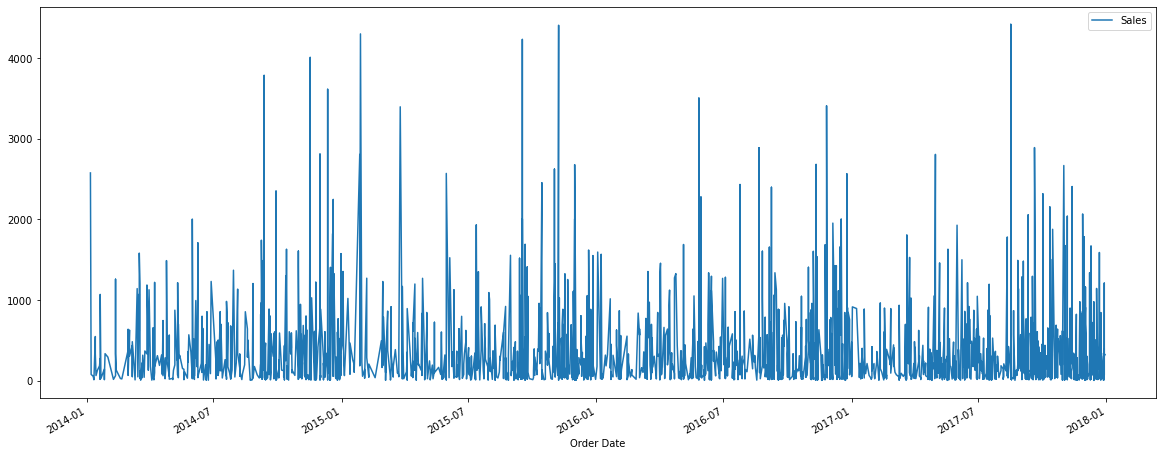

In [4]:
df.plot(figsize=(20,8))
plt.show()

#### DECOMPOSITION OF DATA

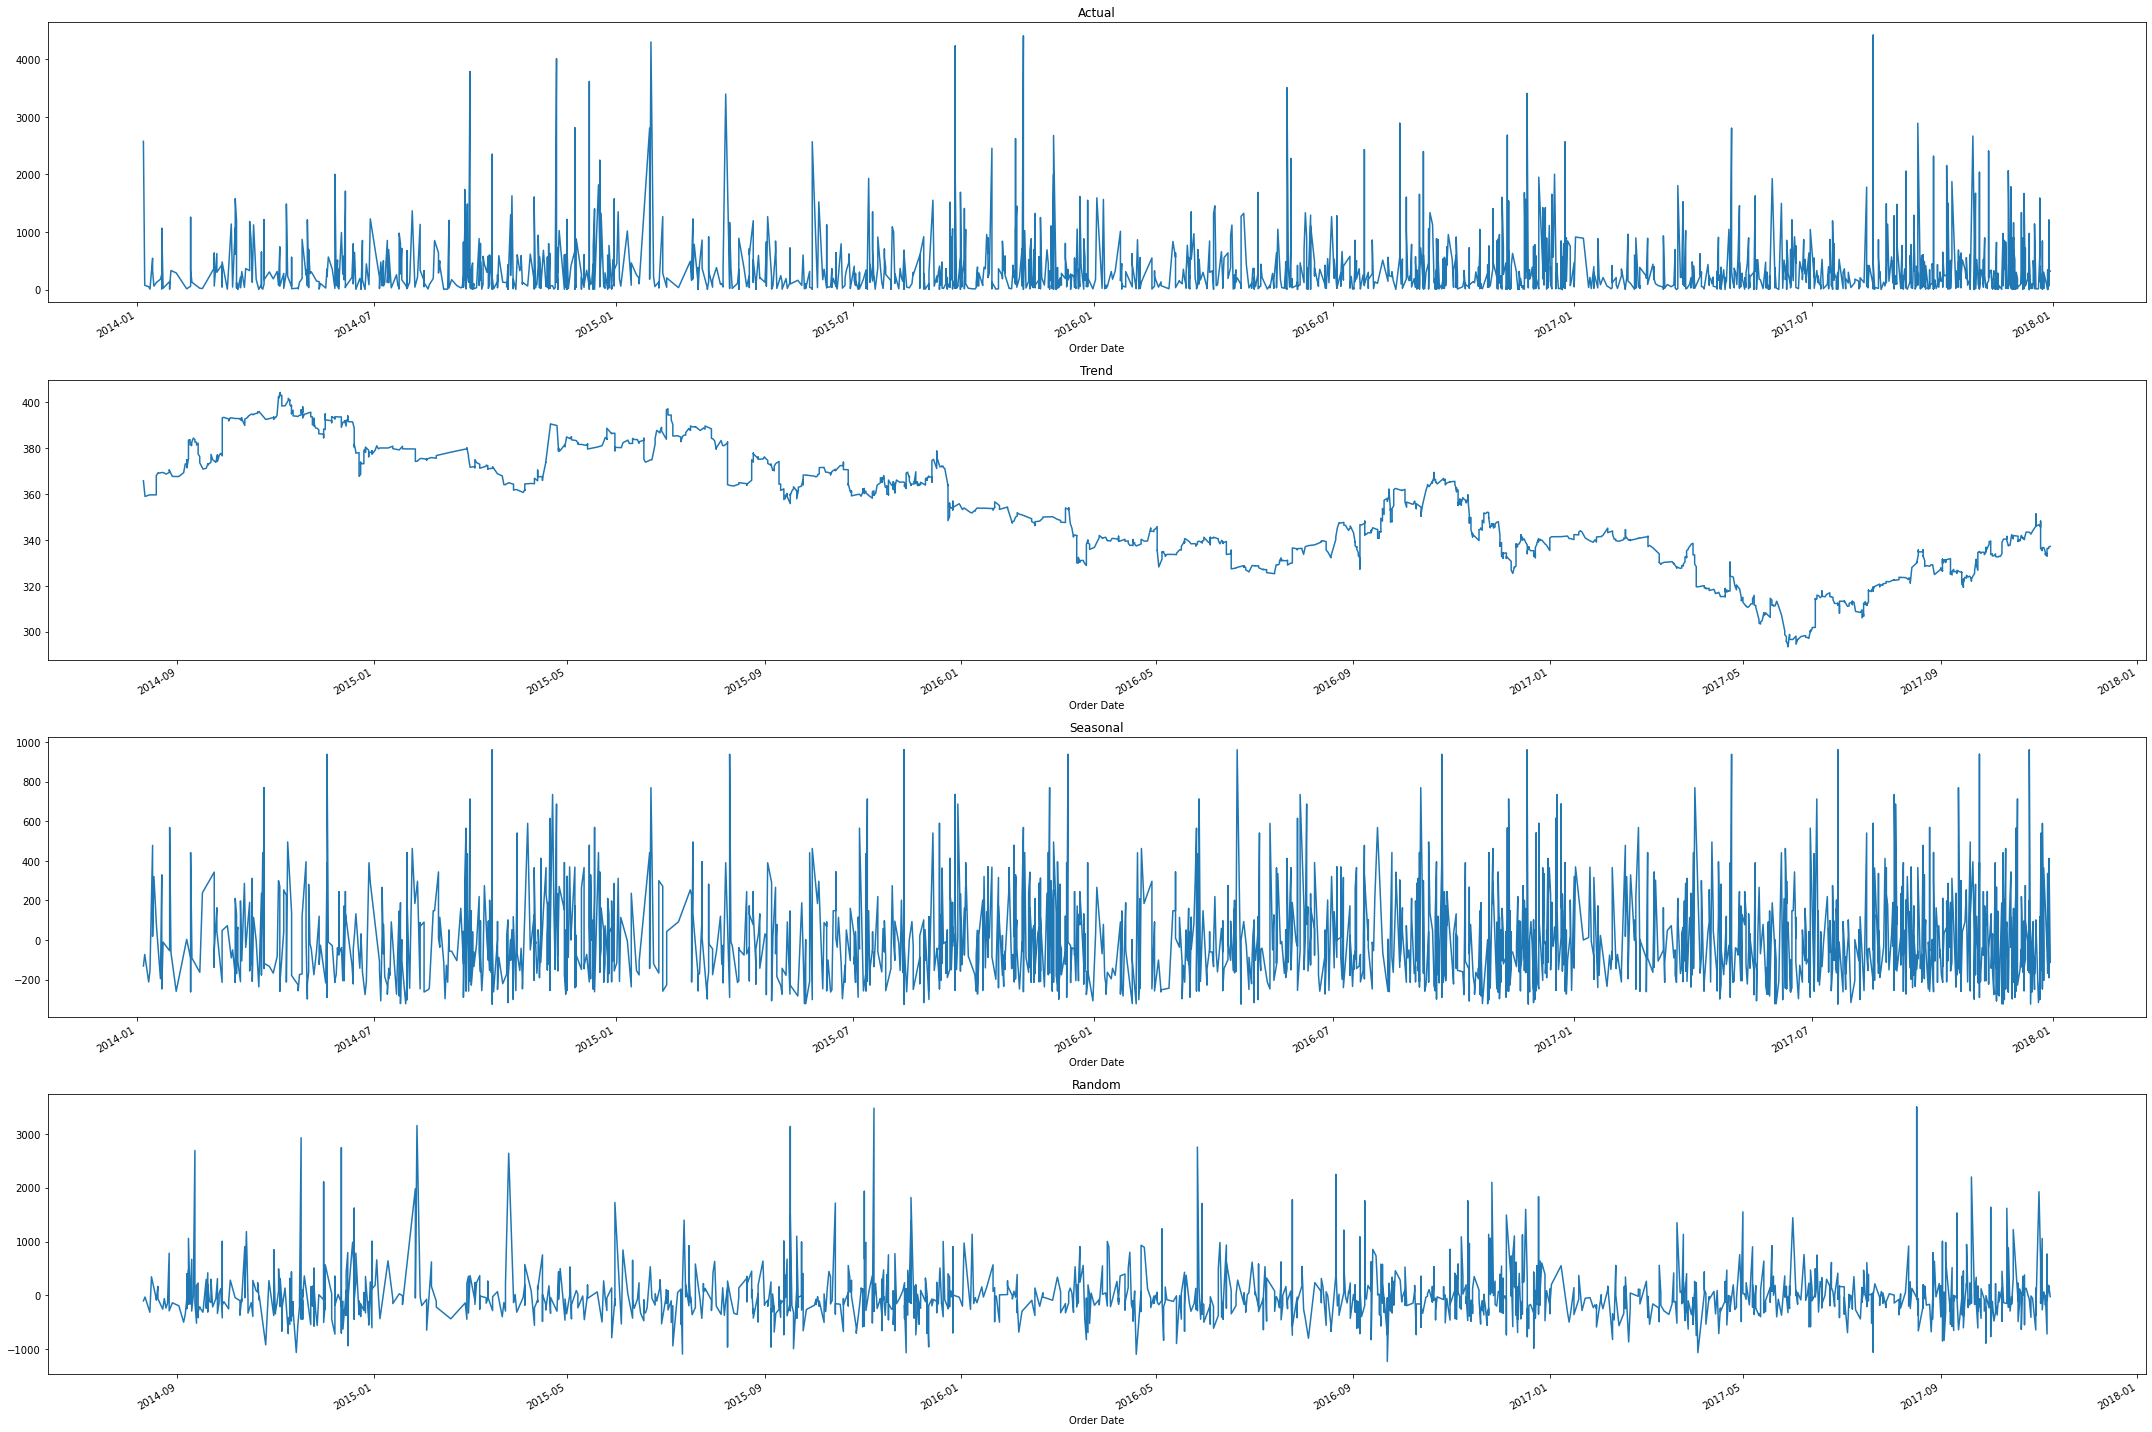

In [5]:
fig,ax = plt.subplots(4,1,figsize=(30,20))

result = seasonal_decompose(df, period=365)

result.observed.plot(ax=ax[0])
ax[0].set_title("Actual")

result.trend.plot(ax=ax[1])
ax[1].set_title("Trend")

result.seasonal.plot(ax=ax[2])
ax[2].set_title("Seasonal")

result.resid.plot(ax=ax[3])
ax[3].set_title("Random")

fig.tight_layout()

plt.show()

There is a decrease in trend

In [6]:
#AS THE DATA IS LARGE, WE ARE SAMPLING THE DATA FOR 7 DAYS
df1=df.resample('M').mean()
print(df1.shape)
df1.head(2)

(48, 1)


,Sales
Order Date,
2014-01-31,312.126250
2014-02-28,262.808286


##### SPLITTING DATASET INTO 70 % TRAIN AND 30 % TEST

In [7]:
split= int(round(0.7 * len(df1),0))
train_df1=df1.iloc[:split]
test_df1=df1.iloc[split:]
print(train_df1.shape,test_df1.shape)
train_df1.head(2),test_df1.head(2)

(34, 1) (14, 1)


(                 Sales
 Order Date            
 2014-01-31  312.126250
 2014-02-28  262.808286,
                  Sales
 Order Date            
 2016-11-30  392.390479
 2016-12-31  436.651369)

### TASK 2

In [8]:
# Augmented dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]

    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

In [9]:
#TRAINING
r=checkStationarity(train_df1)
print('TRAINING:\n',r)

#TESTING
r=checkStationarity(test_df1)
print(r)
# difference in the data 
diff = test_df1 - test_df1.shift()
print(diff)
# remove the Nulls from the differenced data
print('Before removing Nulls,total records = ', len(diff))
diff.dropna(inplace = True)
print('After removing Nulls, total records = ', len(diff))
print(diff)
# checking again the differenced data for stationarity
checkStationarity(diff)

TRAINING:
 p-value=2.1944681068697505e-07. Data is stationary
p-value=0.5730894811109385. Data is not stationary
                 Sales
Order Date            
2016-11-30         NaN
2016-12-31   44.260890
2017-01-31 -188.150036
2017-02-28   15.588567
2017-03-31   22.579700
2017-04-30  -80.625098
2017-05-31  113.909426
2017-06-30   52.763458
2017-07-31 -145.543886
2017-08-31  168.771987
2017-09-30  -46.208065
2017-10-31  -41.511109
2017-11-30   66.083940
2017-12-31  -78.013396
Before removing Nulls,total records =  14
After removing Nulls, total records =  13
                 Sales
Order Date            
2016-12-31   44.260890
2017-01-31 -188.150036
2017-02-28   15.588567
2017-03-31   22.579700
2017-04-30  -80.625098
2017-05-31  113.909426
2017-06-30   52.763458
2017-07-31 -145.543886
2017-08-31  168.771987
2017-09-30  -46.208065
2017-10-31  -41.511109
2017-11-30   66.083940
2017-12-31  -78.013396


'p-value=2.298676578196605e-05. Data is stationary'

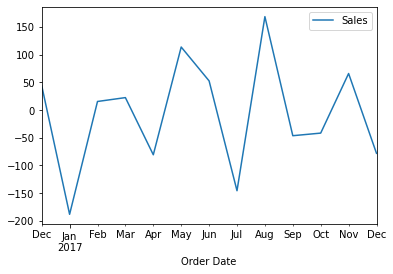

In [10]:
#PLOTTING THE DIFFERENCED DATA FOR ENTIRE DATAFRAME
diff.plot()
plt.show()

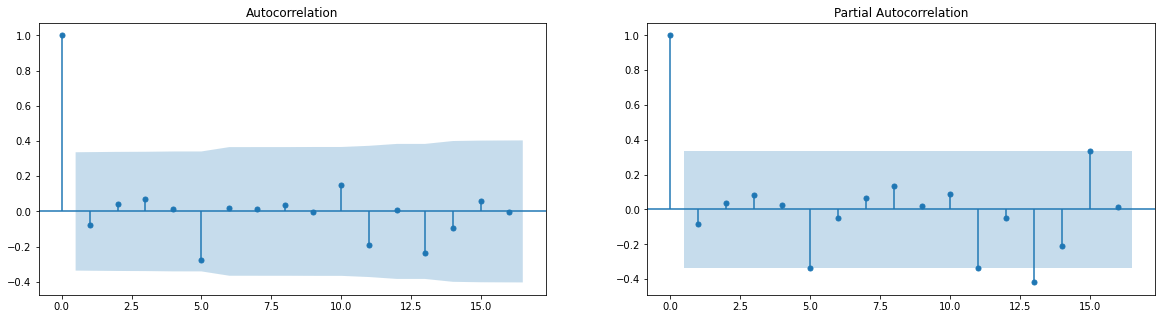

In [11]:
#plotting ACF and PACF plots
fig,ax=plt.subplots(1,2,figsize=(20,5))
plot_acf(train_df1,ax=ax[0])
plot_pacf(train_df1,ax=ax[1])
plt.show()

### TASK 3

### ARMA MODEL

In [12]:
# TO FIND P,Q VALUES
aic=[]
llf=[]
d=0;
for p in range(0,3):
    for q in range(0,3):
            print('p=',p,'d=',d,'q=',q)
            m = ARIMA(train_df1,order=(p,d,q)).fit()
            aic.append(m.aic)
            llf.append(m.llf)
            m.summary()
            print('AIC=',m.aic,'LLR=',m.llf)      

p= 0 d= 0 q= 0
AIC= 409.685535797707 LLR= -202.8427678988535
p= 0 d= 0 q= 1
AIC= 411.48394713842396 LLR= -202.74197356921198
p= 0 d= 0 q= 2
AIC= 413.3748543221948 LLR= -202.6874271610974
p= 1 d= 0 q= 0
AIC= 411.4661998858802 LLR= -202.7330999429401
p= 1 d= 0 q= 1
AIC= 413.45163223501527 LLR= -202.72581611750763
p= 1 d= 0 q= 2
AIC= 415.26697190648423 LLR= -202.63348595324211
p= 2 d= 0 q= 0
AIC= 413.4252561549095 LLR= -202.71262807745475
p= 2 d= 0 q= 1
AIC= 415.377834528975 LLR= -202.6889172644875
p= 2 d= 0 q= 2
AIC= 414.57569084946397 LLR= -201.28784542473198


In [13]:
max(llf)  #-->2,0,2

-201.28784542473198

In [14]:
min(aic)#-->0,0,0

409.685535797707

COMPARISON OF ARMA MODELS:
    
we choose   p= 2 q= 2

In [15]:
#PUTTING P,Q VALUES
m = ARIMA(train_df1,order=(2,0,2)).fit()    
print(m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   34
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -201.288
Date:                Fri, 29 Apr 2022   AIC                            414.576
Time:                        11:43:44   BIC                            423.734
Sample:                    01-31-2014   HQIC                           417.699
                         - 10-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        357.0721     35.476     10.065      0.000     287.540     426.604
ar.L1          1.0997      0.409      2.690      0.007       0.299       1.901
ar.L2         -0.7657      0.513     -1.492      0.1

In [16]:
#PREDICTING THE VALUES
predictions = m.predict(0,len(test_df1))
print(predictions)

Order Date
2014-01-31    357.072123
2014-02-28    355.677620
2014-03-31    348.802623
2014-04-30    341.443948
2014-05-31    355.904310
2014-06-30    362.594735
2014-07-31    356.160109
2014-08-31    361.702190
2014-09-30    358.910833
2014-10-31    347.483631
2014-11-30    354.145377
2014-12-31    366.748225
2015-01-31    368.560899
2015-02-28    363.648946
2015-03-31    421.874803
Freq: M, Name: predicted_mean, dtype: float64


In [17]:
# actual vs predicted values
actual = []; pred = []

for i in range(len(test_df1)):
    actual.append(test_df1.iloc[i][0])
    pred.append(predictions[i])

df_res = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res['err'] = df_res.actual - df_res.predicted
print(df_res)

        actual   predicted         err
0   392.390479  357.072123   35.318356
1   436.651369  355.677620   80.973749
2   248.501333  348.802623 -100.301290
3   264.089900  341.443948  -77.354048
4   286.669600  355.904310  -69.234710
5   206.044502  362.594735 -156.550233
6   319.953928  356.160109  -36.206181
7   372.717386  361.702190   11.015196
8   227.173500  358.910833 -131.737333
9   395.945487  347.483631   48.461856
10  349.737422  354.145377   -4.407955
11  308.226313  366.748225  -58.521912
12  374.310253  368.560899    5.749354
13  296.296857  363.648946  -67.352089


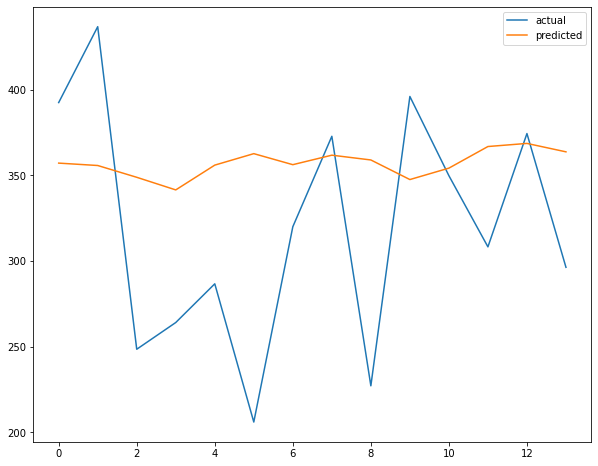

In [18]:
#PLOTTING ACTUAL VS PREDICTED SALES VALUES
df_res.actual.plot(figsize=(10,8),legend=True)
df_res.predicted.plot(legend=True)
plt.show()

In [19]:
mse1 = mean_squared_error(df_res.actual,df_res.predicted)
rmse1=np.sqrt(mse1)
rmse1,mse1

(76.67121548927598, 5878.475284602993)

In [20]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


### TASK 4

### ARIMA MODEL

In [21]:
#TO FIND P,Q,D VALUES
aic=[]
llf=[]
for p in range(0,3):
    for q in range(0,3):
        for d in range(0,2):
            print('p=',p,'d=',d,'q=',q)
            m1 = ARIMA(train_df1,order=(p,d,q)).fit()
            aic.append(m1.aic)
            llf.append(m1.llf)
            m1.summary()
            print('AIC=',m1.aic,'LLR=',m1.llf)      

p= 0 d= 0 q= 0
AIC= 409.685535797707 LLR= -202.8427678988535
p= 0 d= 1 q= 0
AIC= 421.41075074520336 LLR= -209.70537537260168
p= 0 d= 0 q= 1
AIC= 411.48394713842396 LLR= -202.74197356921198
p= 0 d= 1 q= 1
AIC= 402.28809389877637 LLR= -199.14404694938818
p= 0 d= 0 q= 2
AIC= 413.3748543221948 LLR= -202.6874271610974
p= 0 d= 1 q= 2
AIC= 404.2135686364907 LLR= -199.10678431824536
p= 1 d= 0 q= 0
AIC= 411.4661998858802 LLR= -202.7330999429401
p= 1 d= 1 q= 0
AIC= 411.2127467870454 LLR= -203.6063733935227
p= 1 d= 0 q= 1
AIC= 413.45163223501527 LLR= -202.72581611750763
p= 1 d= 1 q= 1
AIC= 404.2017874956574 LLR= -199.1008937478287
p= 1 d= 0 q= 2
AIC= 415.26697190648423 LLR= -202.63348595324211
p= 1 d= 1 q= 2
AIC= 405.4882943942606 LLR= -198.7441471971303
p= 2 d= 0 q= 0
AIC= 413.4252561549095 LLR= -202.71262807745475
p= 2 d= 1 q= 0
AIC= 408.56611729840046 LLR= -201.28305864920023
p= 2 d= 0 q= 1
AIC= 415.377834528975 LLR= -202.6889172644875
p= 2 d= 1 q= 1
AIC= 406.0495567065618 LLR= -199.0247783532

In [22]:
max(llf)  #-->1,1,2

-198.7441471971303

In [23]:
min(aic)#-->0,1,1

402.28809389877637

COMPARISON OF ARIMA MODELS:
    
we choose   p= 1 d= 1 q= 2

In [24]:
#PUTTING P,D,Q VALUES
m1 = ARIMA(train_df1,order=(1,1,2)).fit()    
print(m1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   34
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -198.744
Date:                Fri, 29 Apr 2022   AIC                            405.488
Time:                        11:43:46   BIC                            411.474
Sample:                    01-31-2014   HQIC                           407.502
                         - 10-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9995      0.180     -5.546      0.000      -1.353      -0.646
ma.L1         -0.0071      2.410     -0.003      0.998      -4.730       4.716
ma.L2         -0.9914      0.255     -3.880      0.0

In [25]:
#PREDICTING THE VALUES
predictions = m1.predict(0,len(test_df1))
print(predictions)

Order Date
2014-01-31      0.000000
2014-02-28    308.868095
2014-03-31    288.883919
2014-04-30    327.679262
2014-05-31    338.539803
2014-06-30    313.235257
2014-07-31    342.754192
2014-08-31    338.204583
2014-09-30    337.339410
2014-10-31    339.251483
2014-11-30    352.612329
2014-12-31    345.146897
2015-01-31    355.443519
2015-02-28    372.114909
2015-03-31    396.808490
Freq: M, Name: predicted_mean, dtype: float64


In [26]:
# actual vs predicted values
actual = []; pred = []

for i in range(len(test_df1)):
    actual.append(test_df1.iloc[i][0])
    pred.append(predictions[i])

df_res = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res['err'] = df_res.actual - df_res.predicted
print(df_res)

        actual   predicted         err
0   392.390479    0.000000  392.390479
1   436.651369  308.868095  127.783274
2   248.501333  288.883919  -40.382586
3   264.089900  327.679262  -63.589362
4   286.669600  338.539803  -51.870203
5   206.044502  313.235257 -107.190755
6   319.953928  342.754192  -22.800264
7   372.717386  338.204583   34.512803
8   227.173500  337.339410 -110.165910
9   395.945487  339.251483   56.694004
10  349.737422  352.612329   -2.874907
11  308.226313  345.146897  -36.920585
12  374.310253  355.443519   18.866733
13  296.296857  372.114909  -75.818053


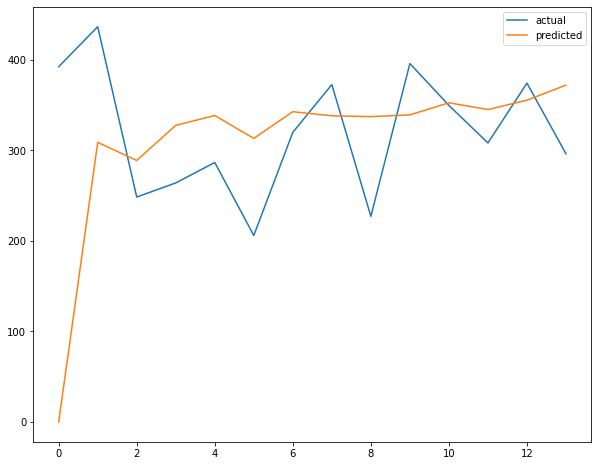

In [27]:
#PLOTTING ACTUAL VS PREDICTED SALES VALUES
df_res.actual.plot(figsize=(10,8),legend=True)
df_res.predicted.plot(legend=True)
plt.show()

In [28]:
mse2 = mean_squared_error(df_res.actual,df_res.predicted)
rmse2=np.sqrt(mse2)
rmse2,mse2

(123.83486642824181, 15335.074143300491)

In [29]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


#### FORECASTING THE DATA FOR ARIMA MODEL

In [30]:
fcast=m1.forecast(len(test_df1))
fcast

2016-11-30    375.135038
2016-12-31    339.536057
2017-01-31    375.115629
2017-02-28    339.555455
2017-03-31    375.096242
2017-04-30    339.574831
2017-05-31    375.076876
2017-06-30    339.594187
2017-07-31    375.057531
2017-08-31    339.613521
2017-09-30    375.038208
2017-10-31    339.632834
2017-11-30    375.018905
2017-12-31    339.652126
Freq: M, Name: predicted_mean, dtype: float64

In [31]:
mse22 = mean_squared_error(test_df1,fcast)
rmse22=np.sqrt(mse22)
rmse22,mse22

(80.08492267042692, 6413.59483912826)

In [32]:
fcast = m1.predict(start=len(df1)-1, end=len(df1)+len(test_df1), typ='levels').rename('Forecasted Sales')
print(fcast)

2017-12-31    339.652126
2018-01-31    374.999623
2018-02-28    339.671398
2018-03-31    374.980363
2018-04-30    339.690648
2018-05-31    374.961123
2018-06-30    339.709877
2018-07-31    374.941904
2018-08-31    339.729085
2018-09-30    374.922707
2018-10-31    339.748272
2018-11-30    374.903530
2018-12-31    339.767439
2019-01-31    374.884374
2019-02-28    339.786584
2019-03-31    374.865239
Freq: M, Name: Forecasted Sales, dtype: float64


##### VISUALIZING THE FORECASTED DATA USING ARIMA MODEL

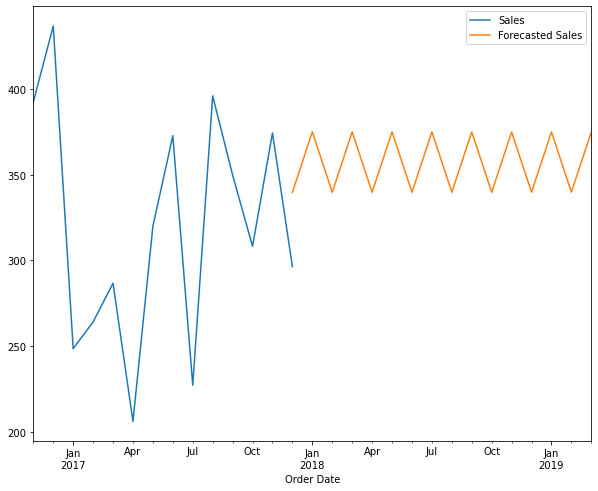

In [33]:
test_df1.plot(figsize=(10,8),legend=True)
fcast.plot(legend=True)
plt.show()

### TASK 5

### SARIMA MODEL

In [34]:
aic=[]
llf=[]
for p in range(0,2):
    for q in range(0,2):
        for d in range(0,2):
            print(p,d,q)
            m2 = sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
            aic.append(m2.aic)
            llf.append(m2.llf)
            m2.summary()
            print('AIC=',m2.aic,'LLR=',m2.llf)      

0 0 0
AIC= 500.54413731127073 LLR= -249.27206865563537
0 1 0
AIC= 279.56519905414336 LLR= -138.78259952707168
0 0 1
AIC= 464.63622989891223 LLR= -229.31811494945612
0 1 1
AIC= 272.5950841807801 LLR= -133.29754209039004
1 0 0
AIC= 435.2786711878874 LLR= -214.6393355939437
1 1 0
AIC= 275.1199847252025 LLR= -134.55999236260126
1 0 1
AIC= 422.84761280903064 LLR= -206.42380640451532
1 1 1
AIC= 273.5595148329022 LLR= -131.7797574164511


In [35]:
max(llf) #-->1,1,1

-131.7797574164511

In [36]:
min(aic) #-->0,1,1

272.5950841807801

Comparison of SARIMA Models:-
    
We choose p=1,d=1,q=1

In [37]:
#PUTTING P,D,Q VALUES
p=1;d=1;q=1
m2 = sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
print(m2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   34
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -131.780
Date:                            Fri, 29 Apr 2022   AIC                            273.560
Time:                                    11:43:49   BIC                            278.782
Sample:                                01-31-2014   HQIC                           274.693
                                     - 10-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1010      0.386      0.262      0.794      -0.656       0.857
ma.L1         -0.9930     10.024   

In [38]:
#PREDICTING THE VALUES
predictions = m2.predict(0,len(test_df1))
print(predictions)

Order Date
2014-01-31      0.000000
2014-02-28    309.354458
2014-03-31    263.339957
2014-04-30    438.576962
2014-05-31    307.583258
2014-06-30    288.577215
2014-07-31    437.612823
2014-08-31    329.563858
2014-09-30    305.612037
2014-10-31    423.287773
2014-11-30    385.199426
2014-12-31    350.697001
2015-01-31    567.589633
2015-02-28    734.650447
2015-03-31    656.066388
Freq: M, Name: predicted_mean, dtype: float64


In [39]:
# actual vs predicted values
actual1 = []; pred1 = []

for i in range(len(test_df1)):
    actual1.append(test_df1.iloc[i][0])
    pred1.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual1, 'predicted':pred1})
df_res1['err'] = df_res1.actual - df_res1.predicted
print(df_res1)

        actual   predicted         err
0   392.390479    0.000000  392.390479
1   436.651369  309.354458  127.296911
2   248.501333  263.339957  -14.838624
3   264.089900  438.576962 -174.487062
4   286.669600  307.583258  -20.913658
5   206.044502  288.577215  -82.532713
6   319.953928  437.612823 -117.658895
7   372.717386  329.563858   43.153529
8   227.173500  305.612037  -78.438537
9   395.945487  423.287773  -27.342286
10  349.737422  385.199426  -35.462005
11  308.226313  350.697001  -42.470689
12  374.310253  567.589633 -193.279381
13  296.296857  734.650447 -438.353590


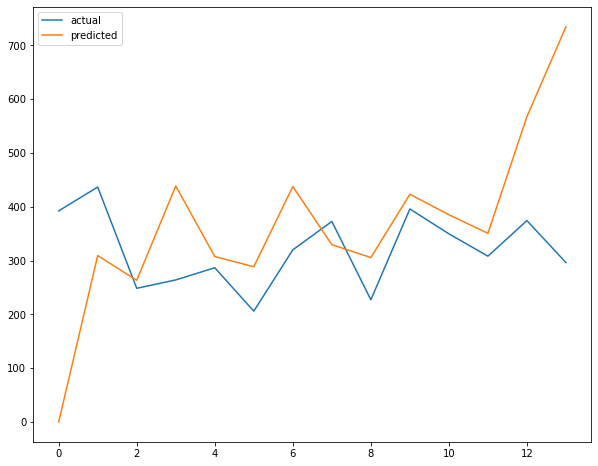

In [40]:
#PLOTTING ACTUAL VS PREDICTED SALES VALUES
df_res1.actual.plot(figsize=(10,8),legend=True)
df_res1.predicted.plot(legend=True)
plt.show()

In [54]:
mse3 = mean_squared_error(df_res1.actual,df_res1.predicted)
rmse3=np.sqrt(mse3)
rmse3,mse3

(181.90811860185386, 33090.56361326613)

In [42]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m2.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


#### FORECASTING DATA FOR SARIMA MODEL

In [43]:
fcast1=m2.forecast(len(test_df1))
fcast1

2016-11-30    328.114283
2016-12-31    376.978624
2017-01-31    615.224005
2017-02-28    261.621487
2017-03-31    437.851715
2017-04-30    277.232683
2017-05-31    269.851907
2017-06-30    326.124494
2017-07-31    310.591637
2017-08-31    257.527206
2017-09-30    422.249787
2017-10-31    342.999004
2017-11-30    361.966680
2017-12-31    351.517168
Freq: M, Name: predicted_mean, dtype: float64

In [44]:
mse33 = mean_squared_error(test_df1,fcast1)
rmse33=np.sqrt(mse33)
rmse33,mse33

(122.6422823938998, 15041.129430785066)

In [60]:
fcast1 = m2.predict(start=len(df1)-1, end=len(df1)+len(test_df1), typ='levels').rename('Forecasted Sales')
print(fcast1)

2017-12-31    351.517168
2018-01-31    436.610615
2018-02-28    212.137084
2018-03-31    345.677772
2018-04-30    321.594352
2018-05-31    303.041233
2018-06-30    320.668866
2018-07-31    309.162038
2018-08-31    345.816182
2018-09-30    349.326066
2018-10-31    268.943569
2018-11-30    325.266916
2018-12-31    350.669569
2019-01-31    528.335463
2019-02-28    225.810118
2019-03-31    385.154432
Freq: M, Name: Forecasted Sales, dtype: float64


##### VISUALIZING THE FORECASTED DATA USING SARIMA MODEL

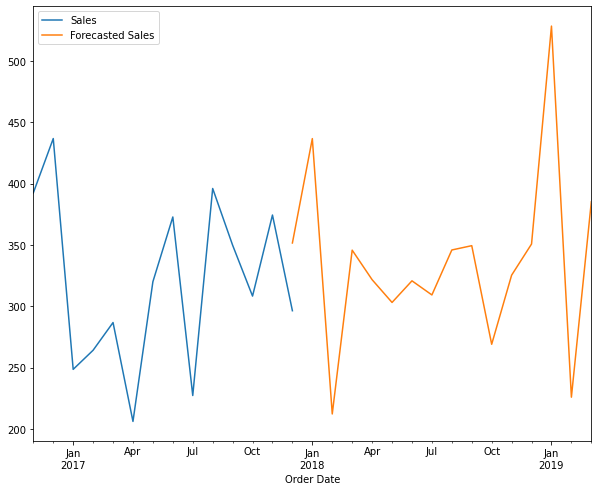

In [61]:
test_df1.plot(figsize=(10,8),legend=True)
fcast1.plot(legend=True)
plt.show()

### TASK 6

### COMPARISON OF ARMA,ARIMA,SARIMA MODELS

##### LLR

In [47]:
print('ARMA:',round(m.llf,2),'\nARIMA:',round(m1.llf,2),'\nSARIMA:',round(m2.llf,2))

ARMA: -201.29 
ARIMA: -198.74 
SARIMA: -131.78


##### AIC

In [48]:
print('ARMA:',round(m.aic,2),'\nARIMA:',round(m1.aic,2),'\nSARIMA:',round(m2.aic,2))

ARMA: 414.58 
ARIMA: 405.49 
SARIMA: 273.56


##### BIC

In [49]:
print('ARMA:',round(m.bic,2),'\nARIMA:',round(m1.bic,2),'\nSARIMA:',round(m2.bic,2))

ARMA: 423.73 
ARIMA: 411.47 
SARIMA: 278.78


##### MSE

In [55]:
print('ARMA for predicted data:',round(mse1,2),\
      '\nARIMA for predicted data:',round(mse2,2),\
      '\nSARIMA for predicted data:',round(mse3,2))

ARMA for predicted data: 5878.48 
ARIMA for predicted data: 15335.07 
SARIMA for predicted data: 33090.56


##### RMSE

In [56]:
print('ARMA for predicted data:',round(rmse1,2),\
      '\nARIMA for predicted data:',round(rmse2,2),\
      '\nSARIMA for predicted data:',round(rmse3,2))

ARMA for predicted data: 76.67 
ARIMA for predicted data: 123.83 
SARIMA for predicted data: 181.91


In [57]:
print('ARIMA for forecast data:',round(rmse22,2),'\nSARIMA for forecast data:',round(rmse33,2))

ARIMA for forecast data: 80.08 
SARIMA for forecast data: 122.64


#### SARIMA MODEL HAS BETTER LLR,AIC AND BIC VALUES WHILE COMPARING WITH THE OTHER TWO MODELS

In [53]:
#END